In [272]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict

In [2]:
# Preamble

directory = "/home/stef/hiec/data/embeddings/proteins/"
path = "/home/stef/hiec/data/embeddings/proteins/A0A1H8KP99 | 3.6.3.19.pt"
model = torch.load(path)
print(model.keys())
type(model['mean_representations'])
rep = model['mean_representations']
em = rep[32]
em.shape

dict_keys(['label', 'mean_representations'])


torch.Size([1280])

In [214]:
# Read in set of unique EC
ec_path = '/home/stef/hiec/data/ec.txt'
unique_ecs = {}
with open(ec_path, 'r') as f:
    temp = f.readlines()

temp = [elt[:-1] for elt in temp] # Remove newline

for i in range(4):
    unique_ecs[i] = []
    
for elt in temp:
    for i in range(4):
        unique_ecs[i].append('.'.join(elt.split('.')[:i+1]))

temp = {}
for k,v in unique_ecs.items():
    temp[k] = sorted(list(set(v)))

unique_ecs = temp
for v in unique_ecs.values():
    print(len(v))


8
78
309
8423


In [228]:
# Helpers

def load_embed(path):
    model = torch.load(path)
    uni_id = model['label'].split(' | ')[0]
    ec = model['label'].split(' | ')[1]
    embed = model['mean_representations'][32]
    return uni_id, ec, embed

def load_class(ec, dir_path):
    '''Loads samples from
    provided EC class given 
    as an array or str'''
    if type(ec) == str:
        ec_str = '| ' + ec + '.'
    else:
        ec_str = '| ' + '.'.join([str(elt) for elt in ec]) + '.'
    
    ids, ecs, embeds = [], [], []
    for elt in os.listdir(dir_path):
        if ec_str in elt:
            path = dir_path + elt
            uni_id, this_ec, embed = load_embed(path)
            ids.append(uni_id)
            ecs.append(this_ec)
            embeds.append(embed)

    if len(embeds) > 0:
        embeds = torch.stack(embeds)

    return ids, ecs, embeds

def dist_between(vec, vec_arr):
    '''Computes Euclidean distance btwn
     vec and each row in vec_arr'''
    vec_repeat = np.tile(vec, (vec_arr.shape[0], 1))
    diff = vec_arr - vec_repeat
    dists = np.linalg.norm(diff, axis=1)
    return dists

def dmax_error(class_embeds, neg_embeds, neg_ecs):
    '''Computes fraction of errors, negative samples
    contained within the hypersphere of radius dmax
    where dmax is the greatest distance between the class
    centroid and a positive sample''' 
    centroid = np.mean(class_embeds, axis=0) # Compute class centroid
    ds_win_class = dist_between(centroid, class_embeds)
    dmax = np.max(ds_win_class) # Get dmax
    ds_neg = dist_between(centroid, neg_embeds) # Distances from negative samples to class centroid
    less_dmax = ds_neg <= dmax
    fps = neg_embeds[np.array(less_dmax)] # "False positives" fall w/in hypersphere
    tns = neg_embeds[~np.array(less_dmax)] # "True negatives" fall outside of hypersphere
    fp_ecs = neg_ecs[np.array(less_dmax)] 
    tn_ecs = neg_ecs[~np.array(less_dmax)]
    error_frac = fp_ecs.shape[0] / neg_embeds.shape[0]
    # return error_frac, fps, tns, fp_ecs, tn_ecs
    return error_frac

In [64]:
# Load ESM embeds

n_levels = 4 # Levels of hierarchy in EC
class_ec = np.array([1,1,1]) # Class specifier. Maybe be of len 1 to n_levels
class_ec_ext = np.concatenate([class_ec, np.zeros(shape=(n_levels-len(class_ec)))]) # Extend class_ec w/ zeros
ids, class_ecs, class_embeds = load_class(class_ec, directory) # Load class
class_ecs = np.array([np.array(elt.split('.')).astype(int) for elt in class_ecs])
class_embeds = np.array(class_embeds)

# Load negative samples
neg_ecs = [] # ECs of negative samples (outside of class)
neg_embeds = []
for i, elt in enumerate(os.listdir(directory)[::10000]):
    _, this_ec, this_embed = load_embed(directory + elt)
    neg_ecs.append(np.array(this_ec.split('.')).astype(int)) # EC str -> arr
    neg_embeds.append(this_embed)

neg_embeds = np.vstack(neg_embeds)
neg_ecs = np.vstack(neg_ecs)

In [196]:
# Create dummy data

seed = 825
n_samples = 500
dim = 2 # Dimensionality of space
n_ints = 2 # Number of values a class digit can take
n_levels = 2 # Number of levels in class hierarchy
tot_labels = n_ints * n_levels

unique_labels = []
for i in range(1, n_levels + 1):
    for j in range(1, n_ints + 1):
        unique_labels.append((i, j))

# Random scattering, random labeling
rng = np.random.default_rng(seed)
random_data = rng.normal(size=(n_samples, dim))
random_labels = rng.choice(np.arange(n_ints)+1, size=(n_samples, n_levels))

# Hierarchical and non-hierarchical scatter
# Make ordered labels
n_per_class = n_samples // tot_labels
ordered_labels = []
for i in range(tot_labels):
    ordered_labels += [list(unique_labels[i]) for j in range(n_per_class)]

ordered_labels = np.array(ordered_labels)

cov = np.eye(2) # Define covariance

# Hierachical scatter
means = [[4, 8], [-4, 8], [-4, -8], [4, -8]]
hier_data = []
for i in range(tot_labels):
    hier_data.append(rng.multivariate_normal(means[i], cov, size=n_per_class))

hier_data = np.vstack(hier_data)


# Non-hierarchical scatter
means = [[4, 8], [-4, -8], [-4, 8], [4, -8]]
nh_data = []
for i in range(tot_labels):
    nh_data.append(rng.multivariate_normal(means[i], cov, size=n_per_class))

nh_data = np.vstack(nh_data)


In [197]:
# Select which dummy data and labels
dummy_data = random_data
dummy_labels = ordered_labels
class_ec = np.array([1,2]) # Select which class to specify, could be super class
class_ec_ext = np.concatenate([class_ec, np.zeros(shape=(n_levels-len(class_ec)))]) # Extend class_ec w/ zeros

# Split dummy data
# To get class samples, enforce that their EC number
# is the same as class_ec up to as long class_ec is
class_idx = np.sum(abs(dummy_labels - class_ec_ext)[:,:class_ec.shape[0]], axis=1) == 0
class_embeds = dummy_data[class_idx]
neg_embeds = dummy_data[~class_idx]
class_ecs = dummy_labels[class_idx]
neg_ecs = dummy_labels[~class_idx]

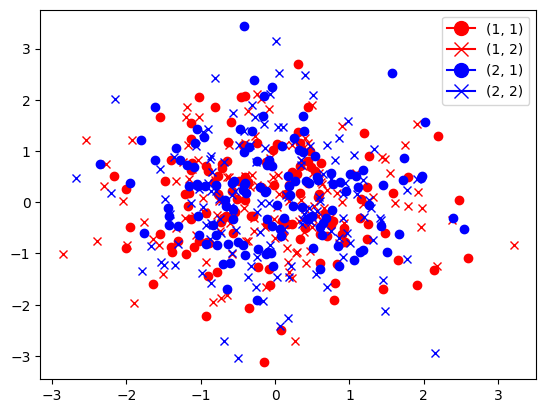

In [198]:
# Plot dummy data

fmt_strs = ['ro', 'rx', 'bo', 'bx']
leg_elts = []
for i in range(tot_labels):
    leg_elts.append(Line2D([0], [0], marker=fmt_strs[i][1], color=fmt_strs[i][0], label=unique_labels[i], markerfacecolor=fmt_strs[i][0], markersize=10))

fig, ax = plt.subplots()
for i in range(n_samples):
    idx = unique_labels.index(tuple(dummy_labels[i]))
    ax.plot(dummy_data[i][0], dummy_data[i][1], fmt_strs[idx])

ax.legend(handles=leg_elts)
plt.show()

In [132]:
# Compute error fraction for one class

centroid = np.mean(class_embeds, axis=0) # Compute class centroid
ds_win_class = dist_between(centroid, class_embeds)
dmax = np.max(ds_win_class) # Get dmax
ds_neg = dist_between(centroid, neg_embeds) # Distances from negative samples to class centroid
less_dmax = ds_neg <= dmax
fps = neg_embeds[np.array(less_dmax)] # "False positives" fall w/in hypersphere
tns = neg_embeds[~np.array(less_dmax)] # "True negatives" fall outside of hypersphere
fp_ecs = neg_ecs[np.array(less_dmax)] 
tn_ecs = neg_ecs[~np.array(less_dmax)]

# Keep track of order of error, i.e.,
# at what EC digit is there the first
# difference with the class ec
first_diff = lambda x : [list((x != 0)[i]).index(True) for i in range(x.shape[0])]
error_order = first_diff(fp_ecs - class_ec_ext)
error_frac = fp_ecs.shape[0] / neg_embeds.shape[0]
print(error_frac)

0.0


In [199]:
# Loop over levels of label hierarchy
# and compute dmax error for dummy data

# Select which dummy data set and labels
dummy_data = random_data
dummy_labels = ordered_labels

unique_class_dict = {}
for j in range(n_levels):
    unique_class_dict[j] = set([tuple([elt[i] for i in range(j+1)]) for elt in unique_labels])

error_fracs = {}
for i in range(n_levels):
    error_fracs[i] = []
    for v in unique_class_dict[i]:
        class_ec = np.array(v) # Select which class to specify, could be super class
        class_ec_ext = np.concatenate([class_ec, np.zeros(shape=(n_levels-len(class_ec)))]) # Extend class_ec w/ zeros
        
        # Split dummy data
        # To get class samples, enforce that their EC number
        # is the same as class_ec up to as long class_ec is
        class_idx = np.sum(abs(dummy_labels - class_ec_ext)[:,:class_ec.shape[0]], axis=1) == 0
        class_embeds = dummy_data[class_idx]
        neg_embeds = dummy_data[~class_idx]
        class_ecs = dummy_labels[class_idx]
        neg_ecs = dummy_labels[~class_idx]

        error_fracs[i].append(dmax_error(class_embeds, neg_embeds, neg_ecs))

In [329]:
# Loop over levels of label hierarchy
# and compute dmax error for ESM embeds

n_levels = 4 # Levels of hierarchy in EC
unique_class_dict = unique_ecs
do_shuffle = False

error_fracs = {}
embed_idxs = defaultdict(lambda : defaultdict(list))

# Load embeddings
ecs = []
embeds = []
for i, elt in enumerate(os.listdir(directory)[::10]):
    _, this_ec, this_embed = load_embed(directory + elt)
    ecs.append(np.array(this_ec.split('.')).astype(int)) # EC str -> arr
    embeds.append(this_embed)

    for j in range(n_levels):
        sub_key = '.'.join(this_ec.split('.')[:j+1])
        embed_idxs[j][sub_key].append(i)

embeds = np.vstack(embeds)
ecs = np.vstack(ecs)

# Shuffle data
if do_shuffle:
    rand_idxs = np.arange(embeds.shape[0])
    rng.shuffle(rand_idxs, axis=0) # Shuffle in place
    temp = embeds[rand_idxs]
    old_embeds = embeds
    embeds = temp


# Compute dmax errors
for i in range(n_levels):
    print(f"Level: {i+1}")
    error_fracs[i] = []
    for j in embed_idxs[i]:
        class_embeds = embeds[embed_idxs[i][j]]
        neg_embeds = np.delete(embeds, embed_idxs[i][j], axis=0)
        neg_ecs = np.delete(ecs, embed_idxs[i][j], axis=0)
        error_fracs[i].append(dmax_error(class_embeds, neg_embeds, neg_ecs))

Level: 1
Level: 2
Level: 3
Level: 4


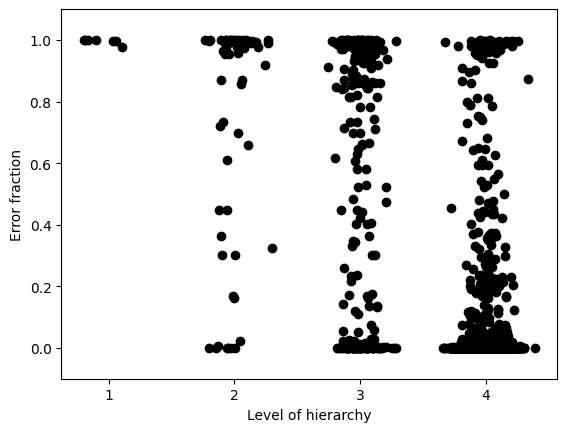

In [330]:
# Plot dmax error
ep = 1e-1
fig, ax = plt.subplots()
for k,v in error_fracs.items():
    ax.plot(np.ones_like(v) * k + rng.normal(0, 1e-1, size=len(v)), v, 'ko')

ax.set_xticks(list(error_fracs.keys()))
ax.set_xticklabels([k + 1 for k in error_fracs.keys()])
ax.set_ylabel('Error fraction')
ax.set_xlabel('Level of hierarchy')
ax.set_ylim(-ep, 1 + ep)
plt.show()